# Electric Vehicle Support Infrastructure Case Study

We will analyse a large dataset, the UK's average daily traffic count. The tasks include extracting vehicle mileage, estimating car growth in future, and estimating electricity requirement to meet electric vehicle demand at some future point. And finally, to decide how to meet any extra generation capability needed cost effectively.

## Install/Import libraries

In [2]:
!pip install fbprophet # Fbprophet is a forecasting tool from Meta

In [15]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

In [16]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/data/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/data


## Basic Analysis

In [17]:
#read csv and display
data = pd.read_csv('dft_traffic_counts_aadf.csv')
data_copy = data.copy()
display(data_copy)
display(data_copy.info())

,id,count_point_id,year,region_id,local_authority_id,road_name,road_category,road_type,start_junction_road_name,end_junction_road_name,...,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles
0,1,27294,2019,5,85,A560,PA,Major,LA Boundary,M56,...,391,2768,158,54,24,7,2,8,253,25927
1,2,1153,2019,3,30,A905,PA,Major,M9,M9 slip,...,35,1787,192,99,72,25,391,216,996,12959
2,3,8024,2019,9,80,M20,TM,Major,2,2,...,149,9592,1167,192,269,403,3799,1788,7619,55977
3,4,20505,2019,4,6,A48(M),TM,Major,LA Boundary,29A,...,276,5603,1052,140,230,106,508,1186,3222,47203
4,5,46628,2019,5,162,A62,PA,Major,A62 Manchester St roundabout,A627 King St,...,186,7242,629,152,152,37,120,196,1285,55089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489154,489155,7538,2019,6,96,A1201,PA,Major,A1199,A503,...,683,2765,127,15,6,3,1,4,156,15628
489155,489156,6670,2019,7,123,A132,PA,Major,A13,A1321,...,21,3158,346,81,180,36,177,127,948,18804
489156,489157,7287,2019,5,75,A572,PA,Major,LA Boundary,A579,...,81,643,67,20,30,1,14,9,141,6534
489157,489158,6584,2019,5,76,A59,PA,Major,A581,A565,...,79,1309,229,48,54,107,148,107,692,9701


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489159 entries, 0 to 489158
Data columns (total 33 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            489159 non-null  int64  
 1   count_point_id                489159 non-null  int64  
 2   year                          489159 non-null  int64  
 3   region_id                     489159 non-null  int64  
 4   local_authority_id            489159 non-null  int64  
 5   road_name                     489159 non-null  object 
 6   road_category                 489159 non-null  object 
 7   road_type                     489159 non-null  object 
 8   start_junction_road_name      376026 non-null  object 
 9   end_junction_road_name        376035 non-null  object 
 10  easting                       489159 non-null  int64  
 11  northing                      489159 non-null  int64  
 12  latitude                      489159 non-nul

None

In [18]:
# Finding amount of missing data in dataframe
print('No. of missing data points for each column:\n\n ' + str(data_copy.isnull().sum()))
print('\nTotal no. of missing data points: ' + str(data_copy.isnull().sum().sum()))

No. of missing data points for each column:

 id                                   0
count_point_id                       0
year                                 0
region_id                            0
local_authority_id                   0
road_name                            0
road_category                        0
road_type                            0
start_junction_road_name        113133
end_junction_road_name          113124
easting                              0
northing                             0
latitude                             0
longitude                            0
link_length_km                  112767
link_length_miles               112767
sequence                        112767
ramp                            362461
estimation_method                    0
estimation_method_detailed           0
pedal_cycles                         0
two_wheeled_motor_vehicles           0
cars_and_taxis                       0
buses_and_coaches                    0
lgvs              

In [19]:
clean_df = data_copy[data_copy['link_length_miles'].notna()]

vehicles = ['pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'all_hgvs', 'all_motor_vehicles']

group_df = clean_df.groupby(['year', 'region_id'])
group_df = group_df.apply(lambda x: x) 

for vehicle in vehicles:
    group_df['miles_' + vehicle] = (group_df[vehicle] * group_df['link_length_miles'])
    

group_df = group_df.groupby(['year', 'region_id']).sum()

vehicle_miles = ['miles_pedal_cycles', 'miles_two_wheeled_motor_vehicles', 'miles_cars_and_taxis', 'miles_buses_and_coaches', 'miles_lgvs', 'miles_all_hgvs', 'miles_all_motor_vehicles']


print('\nTotal daily average miles for each vehicle based on year and region_id')
display(group_df[[*vehicle_miles]])


Total daily average miles for each vehicle based on year and region_id


miles_pedal_cycles  miles_two_wheeled_motor_vehicles  \
year region_id                                                         
2000 1                   101155.85                         443949.80   
     2                    85100.90                         284139.97   
     3                    79957.49                         253026.27   
     4                    36937.38                         180782.00   
     5                   144374.73                         365883.08   
...                            ...                               ...   
2020 7                   168895.84                         281474.31   
     8                   154609.36                         174860.90   
     9                   288382.43                         489005.15   
     10                   97770.52                         168992.00   
     11                   55109.52                          75260.91   

                miles_cars_and_taxis  miles_buses_and_coaches   miles_lgvs  \
year region_id                                                               
2000 1                   37942817.28                374286.99   4934723.97   
     2                   32555758.29                257195.87   4607688.26   
     3                   34906079.02                538455.26   4761508.00   
     4                   21358565.61                239785.65   2857037.28   
     5                   46896851.48                556276.20   6023568.23   
...                              ...                      ...          ...   
2020 7                   38467276.54                143532.19   9837900.00   
     8                   27758554.04                148571.57   6769688.57   
     9                   57270707.43                229358.05  14012204.28   
     10                  31108255.24                132249.96   7115855.44   
     11                  12631959.52                 81433.45   2670911.66   

                miles_all_hgvs  miles_all_motor_vehicles  
year region_id                                            
2000 1              3531199.80               47226977.84  
     2              4731077.79               42435860.18  
     3              3482304.21               43941372.76  
     4              1775009.40               26411179.94  
     5              5171818.29               59014397.28  
...                        ...                       ...  
2020 7              5352307.29               54082514.44  
     8              4534151.00               39385828.92  
     9              5780817.79               77782133.11  
     10             4825406.78               43350727.21  
     11              988711.37               16448157.42  

[231 rows x 7 columns]

### Plotting total number of miles each year

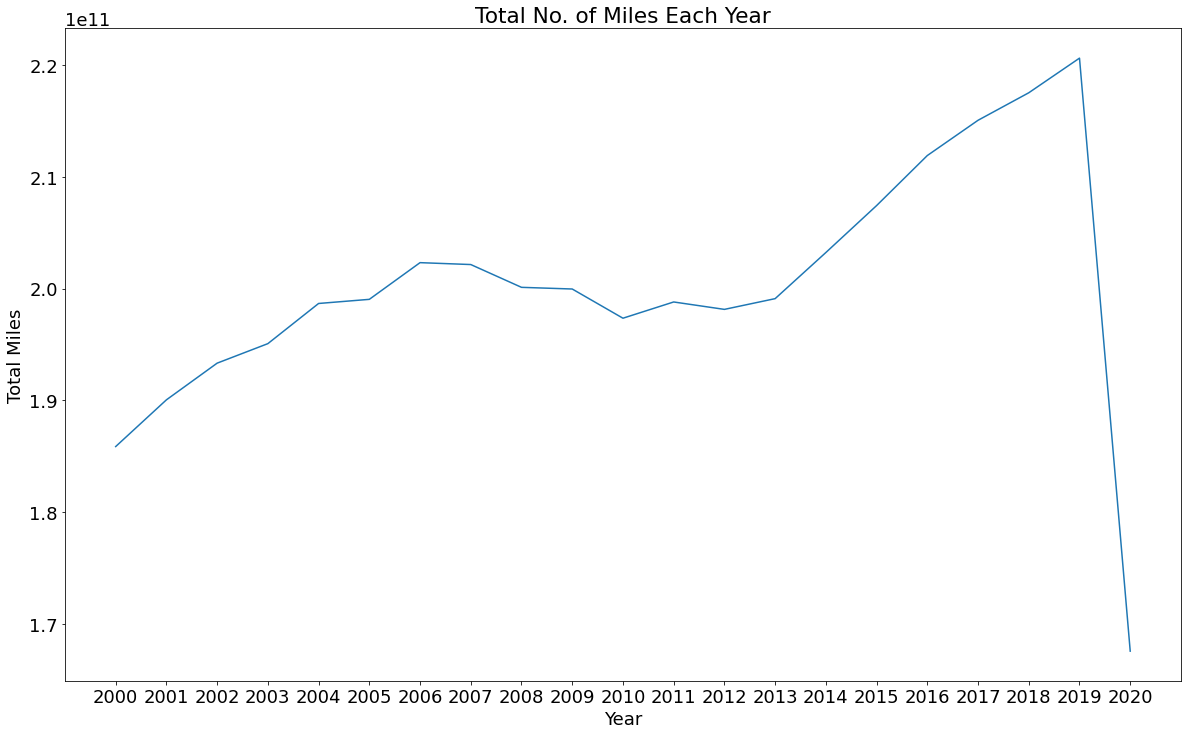

In [20]:
plot4 = group_df.copy()
plot4 = plot4.reset_index()
vehicles_total = plot4.groupby(['year'])
vehicles_total = vehicles_total['miles_all_motor_vehicles'].sum()
vehicles_total = vehicles_total.reset_index()
vehicles_total['miles_total'] = vehicles_total['miles_all_motor_vehicles'] * 365
vehicles_total.plot(x='year', y='miles_total', figsize=(20,12), legend=False)
plt.xlabel('Year')
plt.ylabel('Total Miles')
plt.xticks(vehicles_total['year'].values)
plt.title('Total No. of Miles Each Year')
plt.show()

The total number of miles driven from 2010 to 2019 has risen from 186 billion to 221 billion - a
22% increase. However, there has been a sharp drop in the year 2020 has 167 billion. This could be primarily due
to the global pandemic which led to lockdowns across the country

### Plotting total number of miles and vehicles for each year in each region

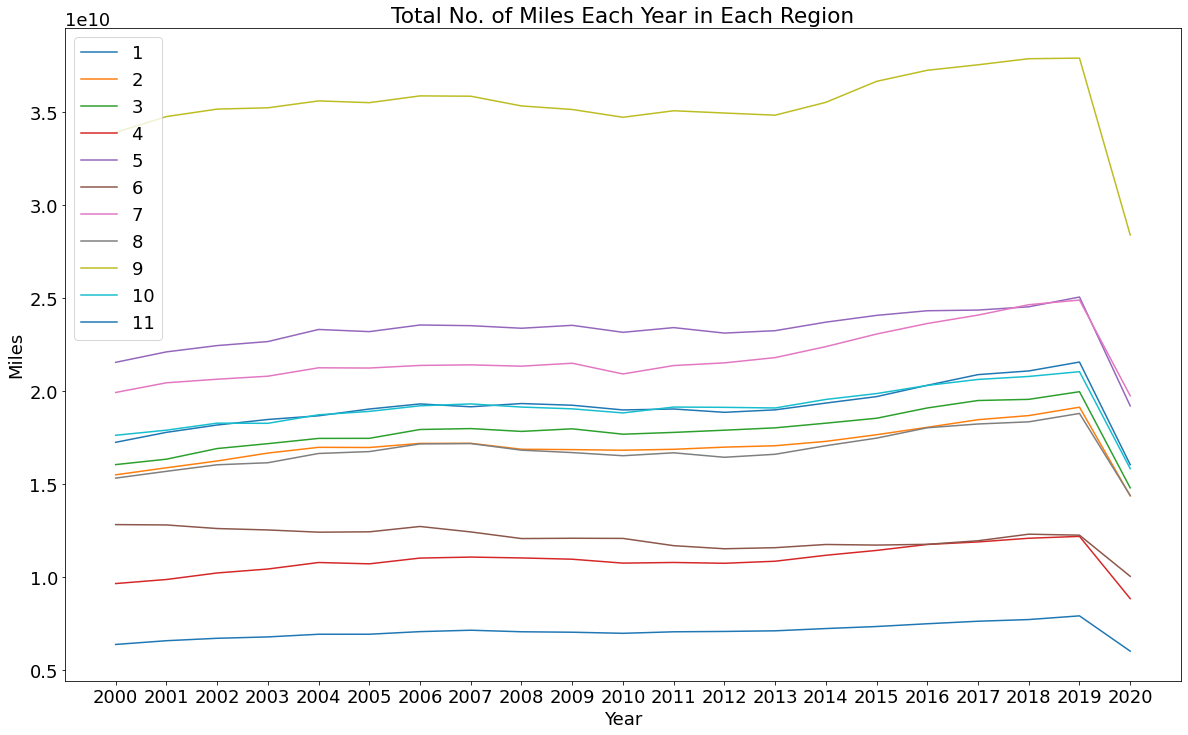

In [24]:
plot2 = group_df[[*vehicle_miles]].copy()
plot2['all_motor_vehicles_total_miles'] = plot2['miles_all_motor_vehicles'] * 365
plot2 = plot2.unstack(level=1)
plot2.plot(y='all_motor_vehicles_total_miles', figsize=(20,12))
plt.xlabel("Year")
plt.ylabel('Miles')
plt.xticks(plot2.index.values)
plt.title('Total No. of Miles Each Year in Each Region')
plt.legend(loc='best')
plt.show()

There has
been a steady amount of traffic in all regions with region 9 having the most and region 1 having
the least traffic across the years.

In [28]:
group_df_by_year = group_df[[*vehicles]].reset_index()
group_df_by_year

,year,region_id,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs,all_motor_vehicles
0,2000,1,100792,291672,20636017,260745,2605344,1453577,25247355
1,2000,2,88768,186004,19687547,216446,2624940,2077346,24792283
2,2000,3,57717,134023,21170893,383728,2770911,1744261,26203816
3,2000,4,25427,99450,12100087,143216,1515231,887118,14745102
4,2000,5,161283,321367,39202443,638153,4966006,3138273,48266242
...,...,...,...,...,...,...,...,...,...
226,2020,7,170304,158855,21050472,98949,4911130,2354342,28573741
227,2020,8,140366,108708,18134122,120108,4064374,2242625,24669942
228,2020,9,284176,320136,34875272,176946,7984423,2705999,46062792
229,2020,10,98448,123231,22121103,123236,4600284,2503029,29470888


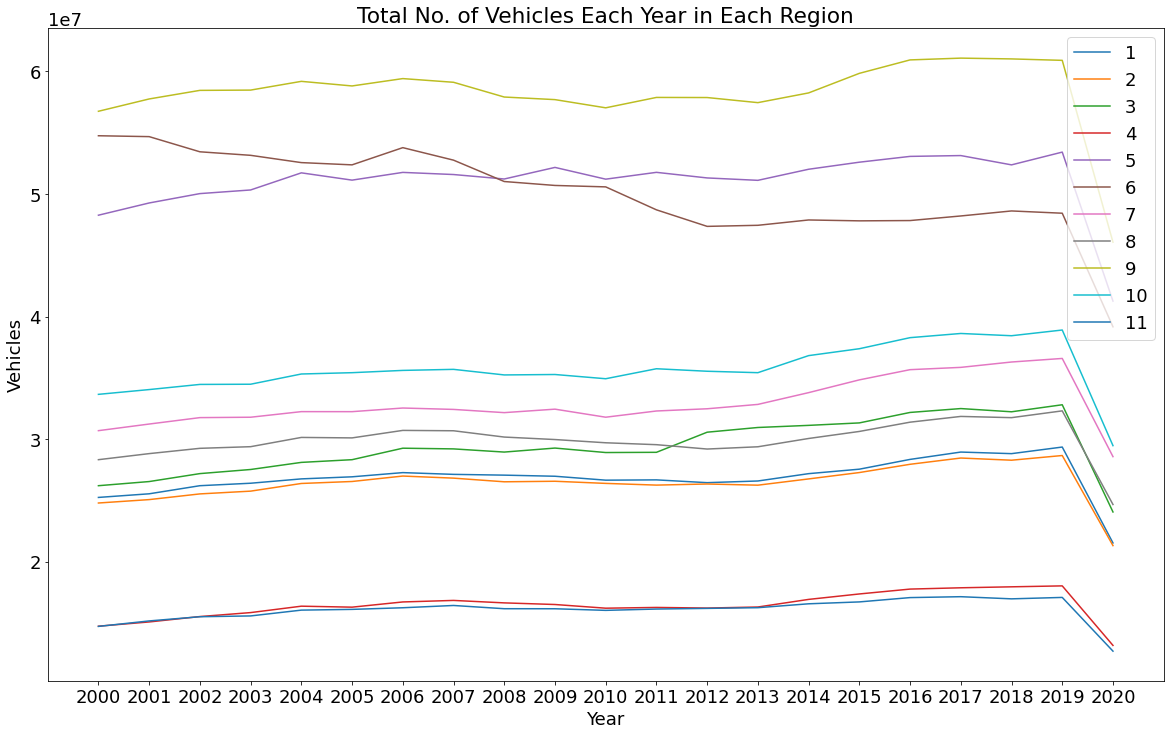

In [27]:
plot5 = group_df[[*vehicles]]
plot5 = plot5.unstack(level=1)
plot5.plot(y='all_motor_vehicles', figsize=(20,12)) 
plt.xticks(plot5.index.values)
plt.xlabel('Year')
plt.ylabel('Vehicles')
plt.title('Total No. of Vehicles Each Year in Each Region')
plt.legend(loc='best')
plt.show()

Region 9 has a higher mileage since it had the most number of vehicles on the road. The opposite is true for Region 1

### Plotting total miles and vehicle count for each vehicle type each year

In [23]:
group_df_by_year

,miles_pedal_cycles,miles_two_wheeled_motor_vehicles,miles_cars_and_taxis,miles_buses_and_coaches,miles_lgvs,miles_all_hgvs
year,,,,,,
2000,4.521066e+08,1.560520e+09,1.475880e+11,1.662071e+09,1.981484e+10,1.524781e+10
2001,4.478348e+08,1.626937e+09,1.511713e+11,1.674058e+09,2.041534e+10,1.516576e+10
2002,4.252167e+08,1.647415e+09,1.540393e+11,1.661962e+09,2.070553e+10,1.528328e+10
2003,4.715854e+08,1.816326e+09,1.546091e+11,1.628276e+09,2.172656e+10,1.530337e+10
2004,4.265071e+08,1.664851e+09,1.569905e+11,1.550551e+09,2.259877e+10,1.587362e+10
2005,4.246762e+08,1.627033e+09,1.569011e+11,1.563269e+09,2.325610e+10,1.570022e+10
2006,5.218924e+08,1.632433e+09,1.587501e+11,1.674086e+09,2.446983e+10,1.580535e+10
2007,4.357549e+08,1.631891e+09,1.573524e+11,1.594380e+09,2.561847e+10,1.596543e+10
2008,5.080227e+08,1.602116e+09,1.561436e+11,1.550462e+09,2.527860e+10,1.555638e+10


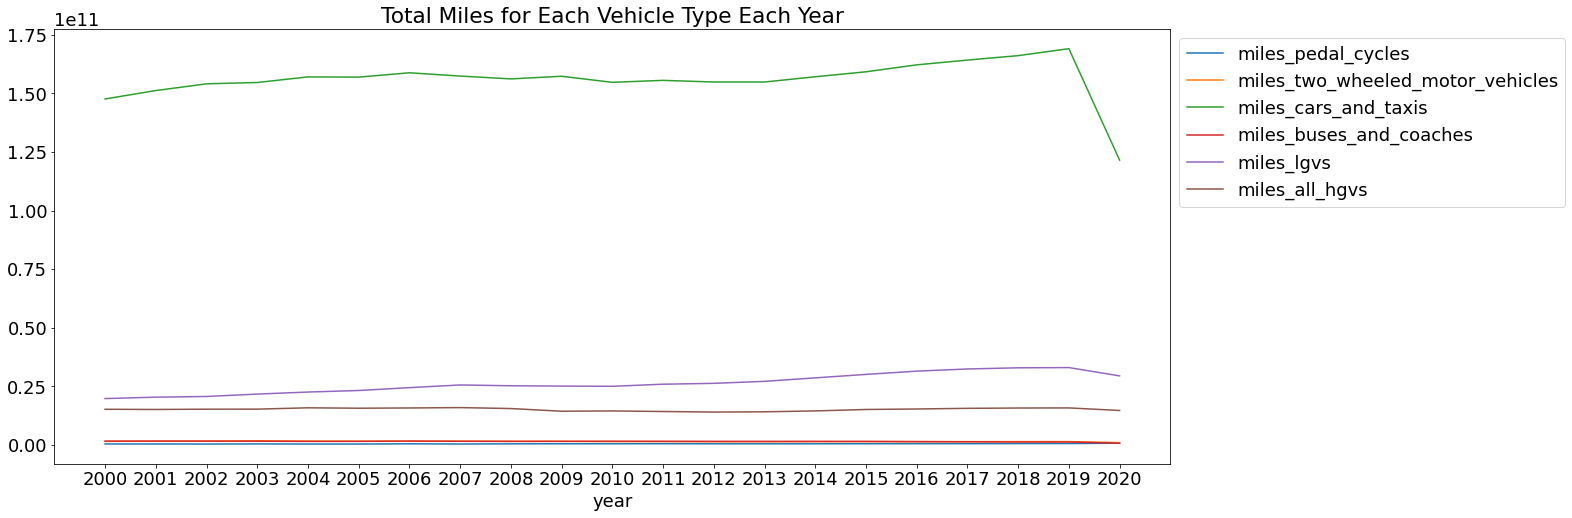

In [22]:
group_df_by_year = group_df.reset_index()
cols = ['year', 'miles_pedal_cycles', 'miles_two_wheeled_motor_vehicles', 'miles_cars_and_taxis', 'miles_buses_and_coaches', 'miles_lgvs', 'miles_all_hgvs']
group_df_by_year = group_df_by_year[[*cols]].groupby('year')                                     
group_df_by_year = group_df_by_year.sum()
group_df_by_year = group_df_by_year*365
group_df_by_year.plot(figsize=(20,8), title='Total Miles for Each Vehicle Type Each Year')
plt.legend(bbox_to_anchor=(1, 1))
plt.xticks(group_df_by_year.index.values)
plt.show()

Cars and taxis make up most
of the traffic usually between 150 billion to around 175 billion miles. The other vehicle types have significantly lower miles travelled. This makes since
most people use a car for travel and taxi drivers spend most of their time on the road. 

### Plotting total number of vehicles each year

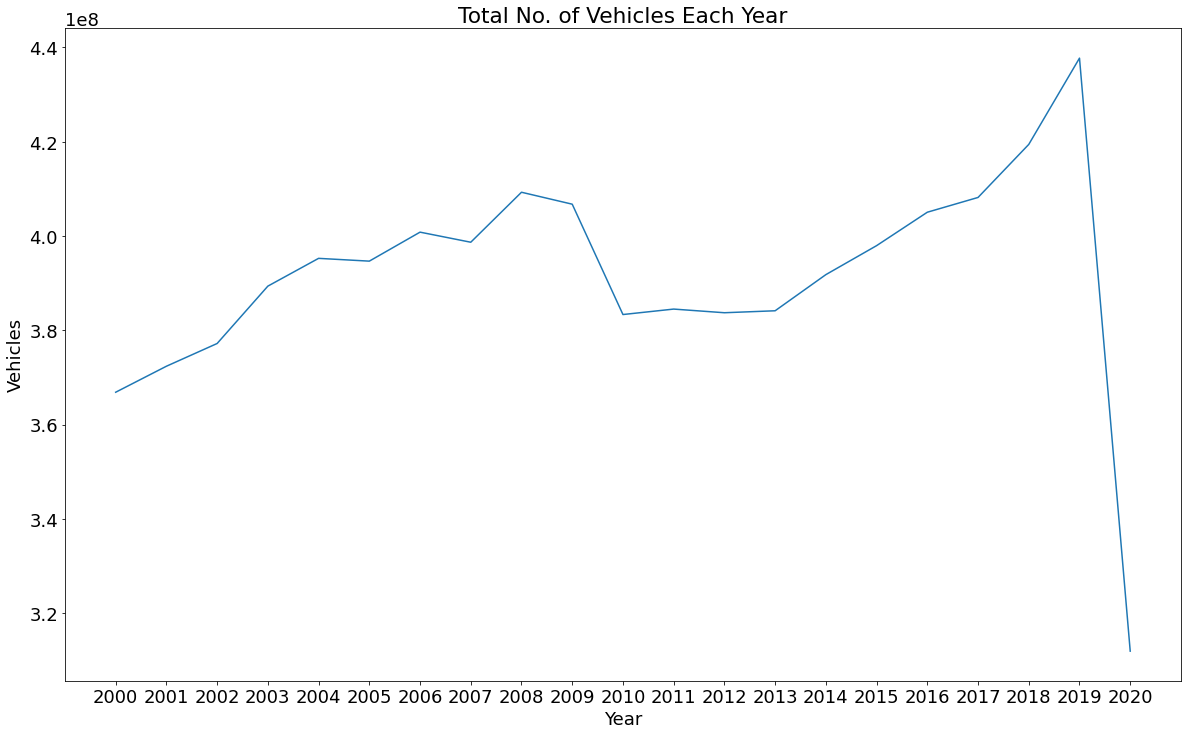

In [25]:
plot3 = data_copy.copy()
plot3 = plot3.groupby(['year'])['all_motor_vehicles']
plot3 = plot3.sum()
data_aggregated = plot3.copy()
plot3.plot(y='all_motor_vehicles', figsize=(20,12))

plt.xlabel("Year")
plt.ylabel("Vehicles")
plt.xticks(data_aggregated.index.values)
plt.title('Total No. of Vehicles Each Year')
plt.show()

The total number of vehicle counts has seen an unsteady
increase from around 360 million in 2000 to around 440 million in 2019 with a decrease from 2008 to 2010. This
decrease may mean that people were not using their vehicles often due to the economic recession
in 2008. There has also been a sharp decrease from 2019 (around 440 million) to 2020 (around 310 million) which is mostly due to the COVID pandemic lockdowns.

### Plotting total count for each vehicle type each year

In [21]:
vehicles_total

,year,miles_all_motor_vehicles,miles_total
0,2000,5.092416e+08,1.858732e+11
1,2001,5.206940e+08,1.900533e+11
2,2002,5.296917e+08,1.933375e+11
3,2003,5.344756e+08,1.950836e+11
4,2004,5.443239e+08,1.986782e+11
5,2005,5.453361e+08,1.990477e+11
6,2006,5.543338e+08,2.023318e+11
7,2007,5.538701e+08,2.021626e+11
8,2008,5.482824e+08,2.001231e+11
9,2009,5.478723e+08,1.999734e+11


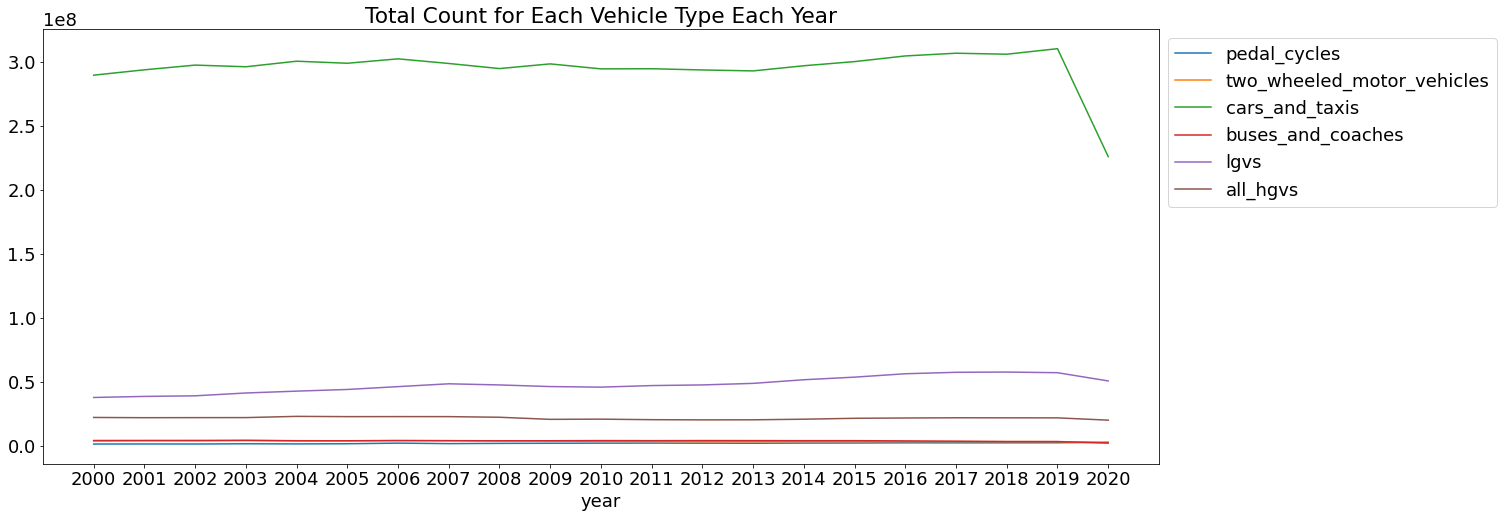

In [29]:
group_df_by_year = group_df[[*vehicles]].reset_index()
cols = ['year', 'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'all_hgvs']
group_df_by_year = group_df_by_year[[*cols]].groupby('year').sum()                                    
group_df_by_year = group_df_by_year
group_df_by_year.plot(figsize=(20,8), title='Total Count for Each Vehicle Type Each Year')
plt.xticks(group_df_by_year.index.values)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Cars and taxis make up most of the vehicles on the road which makes sense since most people drive cars as compare to other vehicle types. This also explains the significant mileage covered by them.

## Regression Analysis

Perform a regression analysis to estimate likely changes in traffic
over the next thirty years

INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


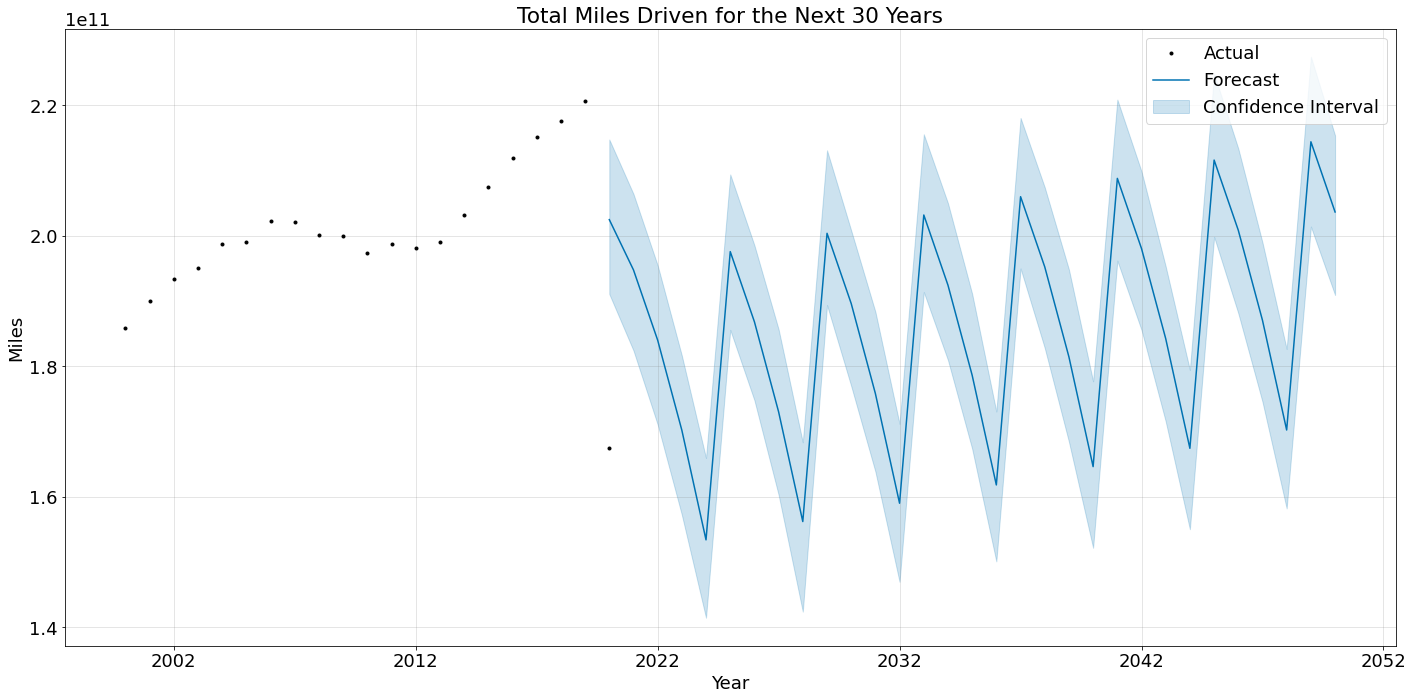

In [30]:
plot6 = group_df.copy()
plot6 = plot6.reset_index()
vehicles_total = plot6.groupby(['year'])
vehicles_total = vehicles_total['miles_all_motor_vehicles'].sum().reset_index()

vehicles_total['year'] = pd.to_datetime(vehicles_total['year'], format='%Y')
vehicles_total['miles_total'] = vehicles_total['miles_all_motor_vehicles'] * 365
vehicles_total[['y', 'ds']] = vehicles_total[['miles_total', 'year']]

prophet = Prophet(weekly_seasonality=False, daily_seasonality=False)
prophet.fit(vehicles_total)

df = prophet.make_future_dataframe(periods=30, freq='Y')
fc = prophet.predict(df)
plot_fc = fc

prophet.plot(fc[20:], figsize=(20,10))
plt.xlabel('Year')
plt.ylabel('Miles')
plt.title("Total Miles Driven for the Next 30 Years")
plt.legend(('Actual', 'Forecast', 'Confidence Interval'))
plt.show()

INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


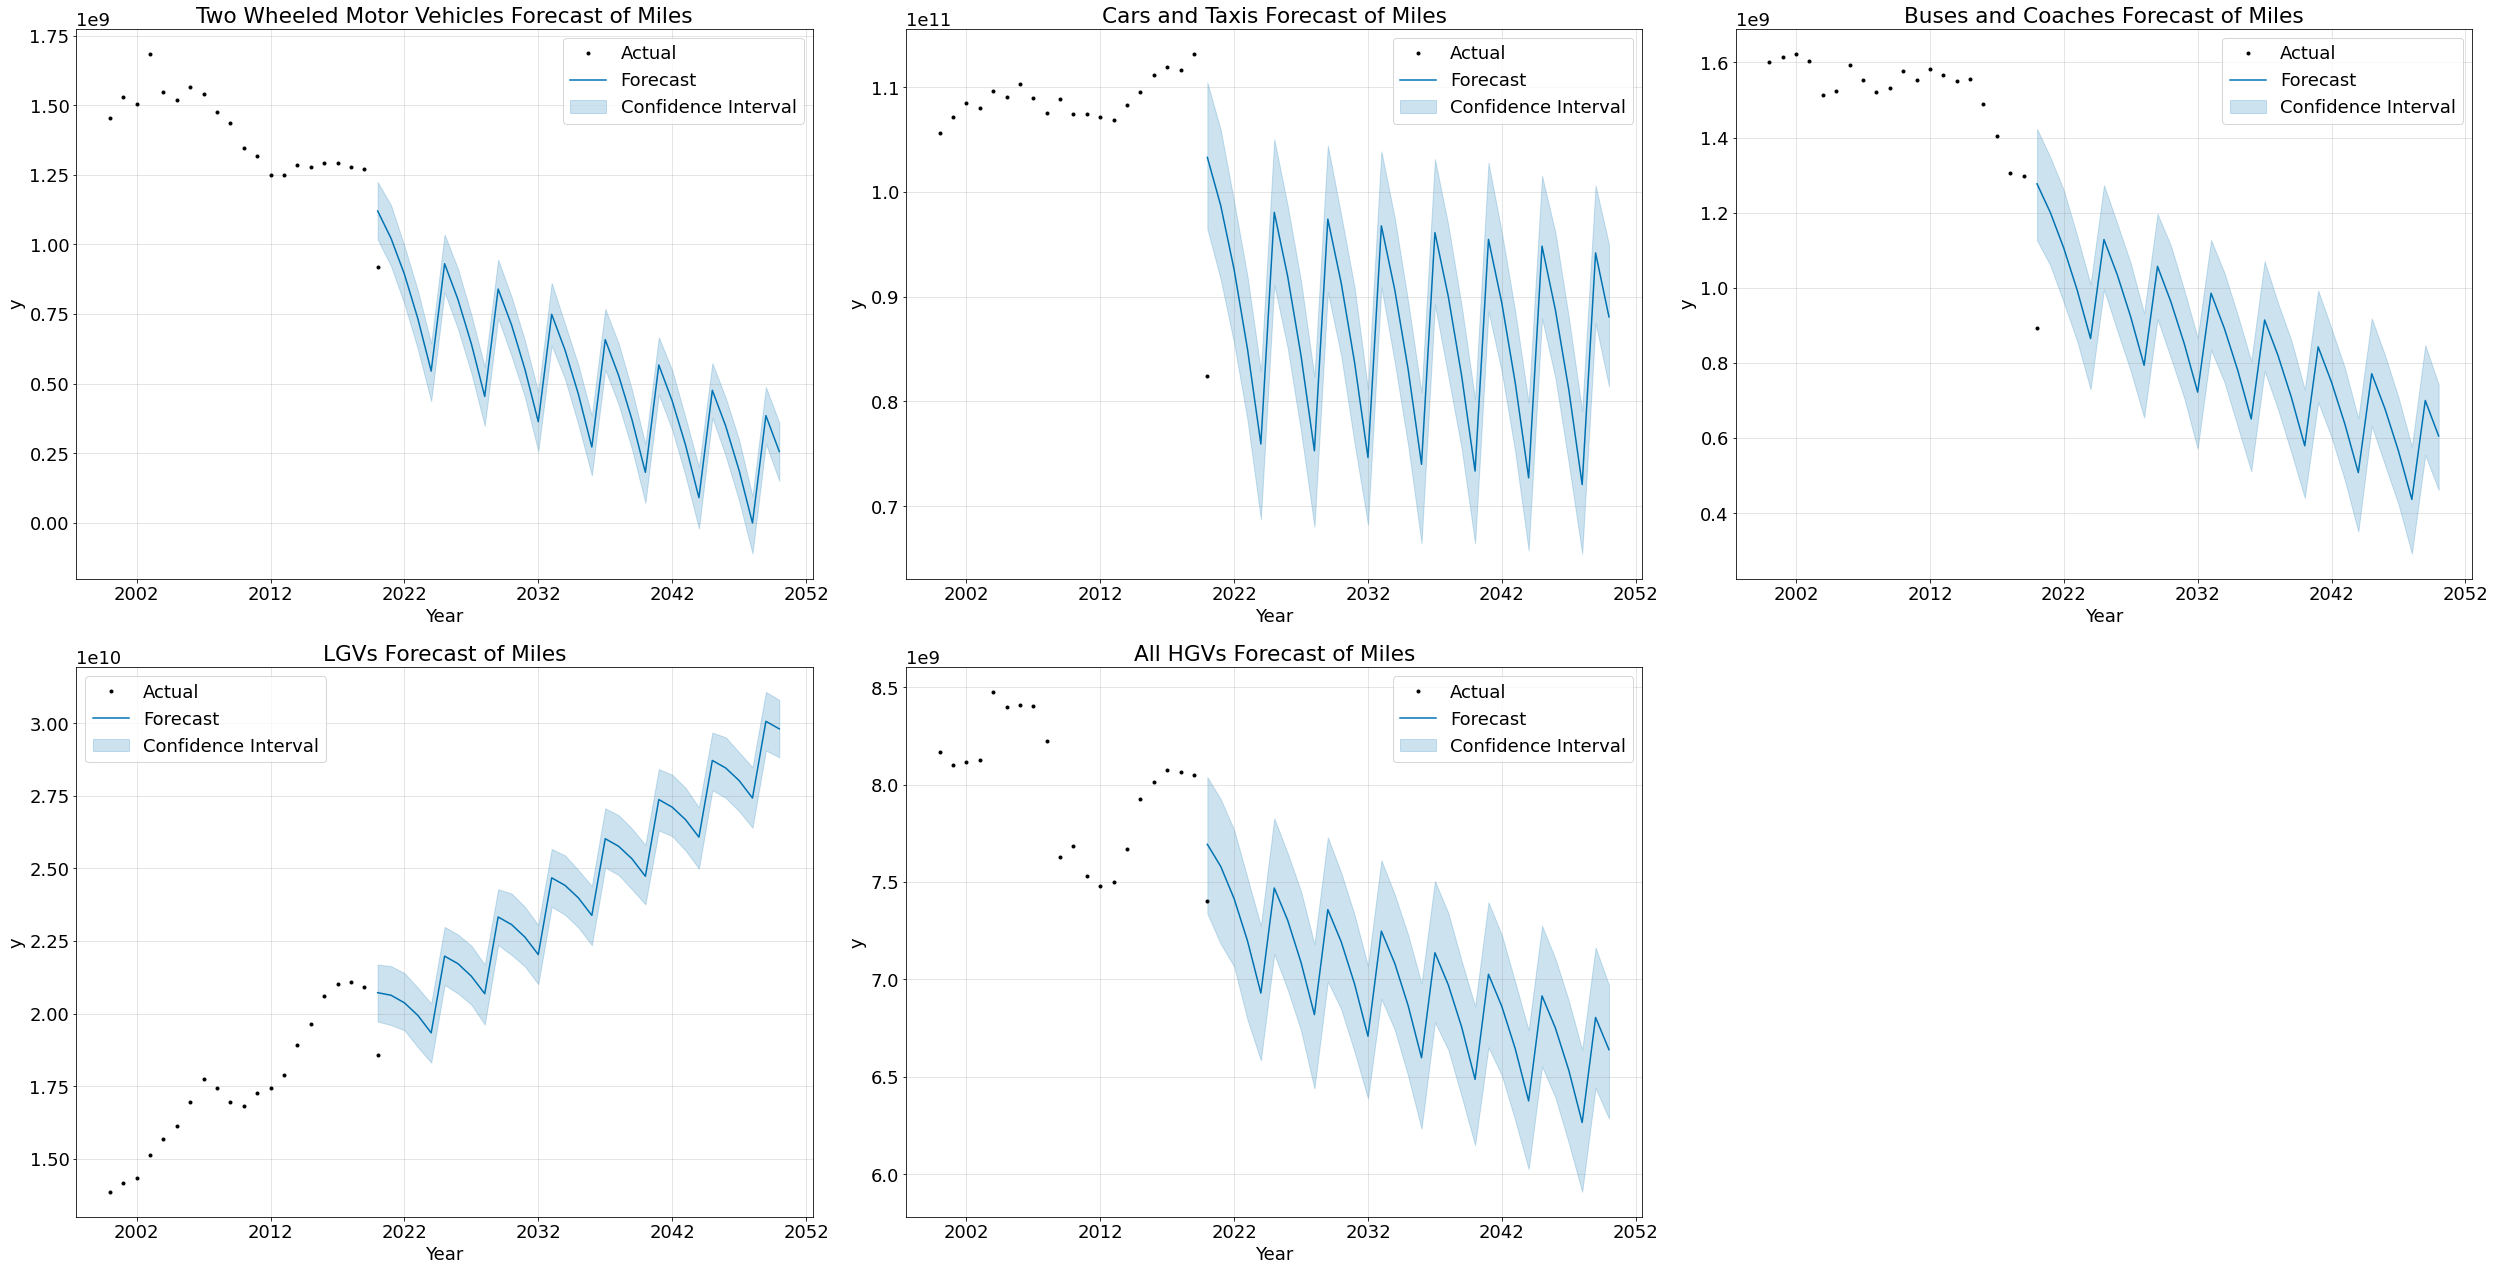

In [31]:
group_df[[*vehicles[1:-1]]] = group_df[[*vehicles[1:-1]]] * 365 #from two wheeled motor vehicles to all hgv's
group_df_reg = group_df[[*vehicles[1:-1]]]
group_df_reg = group_df_reg.groupby(['year']).sum().reset_index()
group_df_reg['year'] = pd.to_datetime(group_df_reg['year'], format='%Y')

f, ax = plt.subplots(2, 3, figsize=(35, 18))
f.delaxes(ax[1,2])
ax = ax.ravel()

# create subplots
index = 0
types = ['Two Wheeled Motor Vehicles', 'Cars and Taxis', 'Buses and Coaches', 'LGVs', 'All HGVs']

for column in group_df_reg:
    prophet2 = Prophet(weekly_seasonality=False, daily_seasonality=False)
    if column == 'year':
        pass
    else:
        group_df_reg[['y', 'ds']] = group_df_reg[[column, 'year']]
        prophet2.fit(group_df_reg)
        ft = prophet2.make_future_dataframe(freq='Y', periods=30)
        fc = prophet2.predict(ft)
        fig = prophet2.plot(fc[20:], ax = ax[index])
        ax[index].set_title(types[index] + ' Forecast of Miles')
        ax[index].set_xlabel('Year')
        ax[index].legend(('Actual', 'Forecast', 'Confidence Interval'))
        index += 1
        
plt.show()


The forecasting tool Prophet, from Meta, helped us to make our predictions. According to our
forecast of annual mileage, there will be an increase from 167 billion in 2020 to about 205 billion
miles by 2050, mostly due to the growth in population. LGVs are the only vehicle type that
shows an increase in the next 30 years. The rest would have a decrease in mileage while cars
and taxis have a steady mileage making them exceptions.


## Estimating the number of electric miles driven each year over the time period and estimate how much power generation will be needed to achieve the same

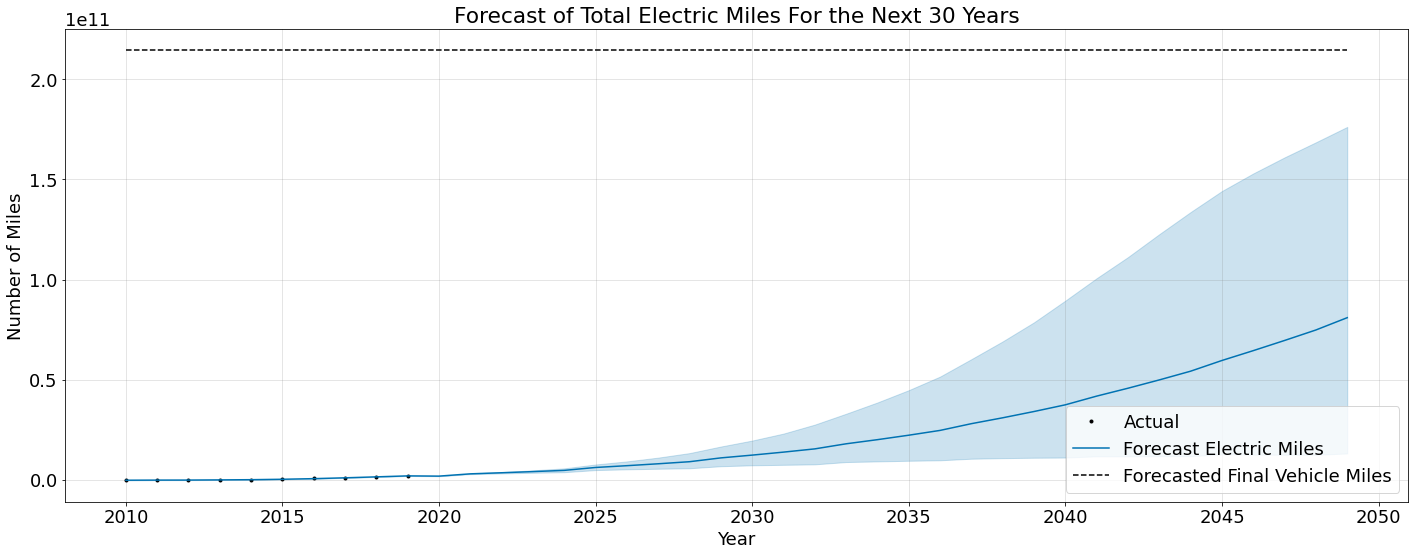

In [32]:
years_list = []
miles_list = [7971800, 25473900, 47634700, 72327900, 192612300, 427104900, 735628000, 1216823700, 1680546500, 2175822700]

for year in range(2010, 2020):
    years_list.append(year)

year_miles_ev = pd.DataFrame(data=list(zip(years_list, miles_list)), columns = ['Year', 'Electric Miles'])
year_miles_ev['Year'] = pd.to_datetime(year_miles_ev['Year'], format='%Y')
year_miles_ev[['y', 'ds']] = year_miles_ev[['Electric Miles', 'Year']]

ev_forecast_miles = Prophet(growth='logistic', weekly_seasonality=False, daily_seasonality=False, changepoints = ['2014-1-1','2015-1-1','2016-1-1','2017-1-1','2018-1-1','2019-1-1'])
year_miles_ev[['cap']] = vehicles_total['miles_total'].max()
ev_forecast_miles.fit(year_miles_ev)

ev_future = ev_forecast_miles.make_future_dataframe(periods=30, freq='Y')
ev_future[['cap']] = plot_fc['yhat'].max()
ev_forecast = ev_forecast_miles.predict(ev_future)

ev_forecast_miles.plot(ev_forecast, figsize=(20,8))
plt.title("Forecast of Total Electric Miles For the Next 30 Years")
plt.xlabel("Year")
plt.ylabel("Number of Miles")
plt.legend(('Actual', 'Forecast Electric Miles', 'Forecasted Final Vehicle Miles'))
plt.show()

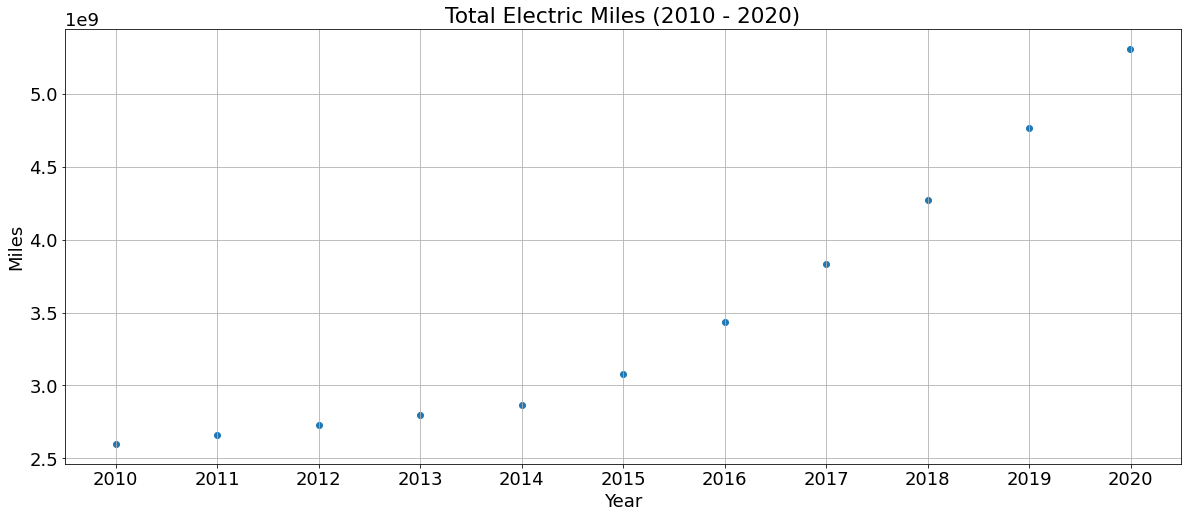

In [33]:
x = ev_forecast['ds'][:11]
y = ev_forecast['trend'][:11]
plt.figure(figsize=(20,8))
plt.scatter(x, y)
plt.grid()
plt.xlabel("Year")
plt.ylabel("Miles")
plt.title("Total Electric Miles (2010 - 2020)")
plt.show()

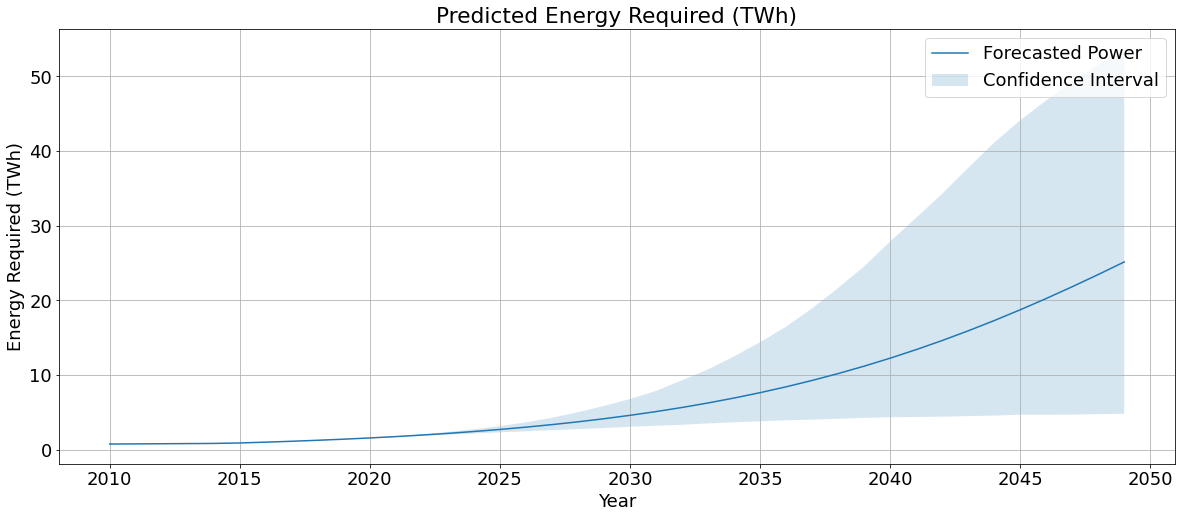

In [35]:
ev_forecast[['upper', 'lower', 'power']] = ev_forecast[['trend_upper', 'trend_lower', 'trend']] * 300
ev_forecast[['upper', 'lower', 'power',]] = ev_forecast[['upper', 'lower', 'power']] / (10**12)

#create the subplots
fig, ax = plt.subplots(figsize=(20, 8))

x = ev_forecast['ds']
y1 = ev_forecast['upper']
y2 = ev_forecast['lower']
y3 = ev_forecast['power']



#organizing and plotting the values
ax.fill_between(x, y1, y2, label='Confidence Interval', alpha=0.18)
plt.ylabel("Energy Required (TWh)")
plt.xlabel("Year")
plt.title("Predicted Energy Required (TWh)")

plt.legend(('Confidence Interval'))
plt.plot(x, y3, label = 'Forecasted Power')
plt.legend(loc="best")
plt.grid()
plt.show()

The last decade has seen a growing demand for electric vehicles in the last few years with 2020
having about 4.5 billion miles being driven as compared to 1.5 billion miles in 2010. Our forecast
predicts that there will be rapid growth in electric vehicle mileage with an increase of almost 120
billion miles from the year 2020 to 2048. This leads to growing energy demands for the future.
About 52 TWh of energy would be required by the year 2048 according to our estimates.


<h2> Finding the cost estimates for various technologies for the years 2025, 2030, 2035 and 2040</h3>
    
<h3>

Source used:       https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/911817/electricity-generation-cost-report-2020.pdf

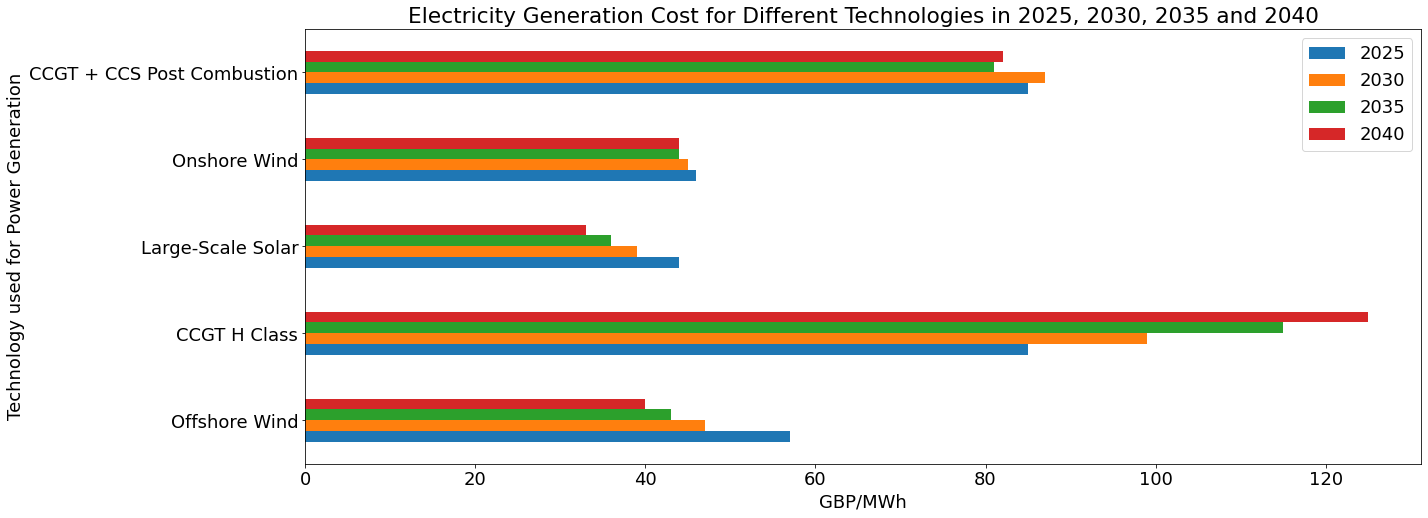

In [36]:
estimates = pd.read_csv('estimates.csv') # data taken from https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/911817/electricity-generation-cost-report-2020.pdf
estimates.plot(kind='barh', y=["2025", "2030", "2035","2040"], x="Technology",  figsize=(20,8), title='Electricity Generation Cost for Different Technologies in 2025, 2030, 2035 and 2040')
plt.ylabel('Technology used for Power Generation')
plt.xlabel('GBP/MWh')
plt.legend(loc='best')
plt.show()

Large-scale solar panels seem to be the most cost-effective solution to meet the power
demands in the future. As solar panels become more common, the cost of electricity
generation will reduce over the years - around 45 GBP/MWh in 2025 to 35 GBP/MWh in 2040.